# Lesson 13 - Состязательные сети.

Недостатки VAE

Из-за плохого способа сравнения оригинальных и восстановленных объектов, сгенерированные ими объекты хоть и похожи на объекты из обучающей выборки, но легко от них отличимы (например, размыты)

GAN’ы впервые были предложены в статье [1, Generative Adversarial Nets, Goodfellow et al, 2014] и сейчас очень активно исследуются.

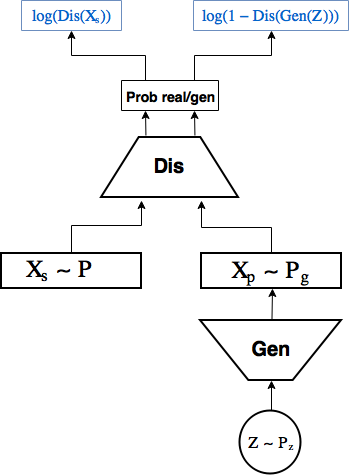

GAN’ы состоят из 2 нейронных сетей:

1-ая — генератор сэмплит случайные числа из какого-то заданного распределения P(Z), например  N(0,I) и генерируют из них объекты $X_p = G(Z; \theta_g)$, которые идут на вход второй сети,

2-ая — дискриминатор получает на вход объекты из выборки X_s и созданные генератором X_p, и учится предсказывать вероятность того, что конкретный объект реальный, выдавая скаляр $D(X; \theta_d)$

## Обучение

Генератор и дискриминатор обучаются отдельно, но в рамках одной сети.

Делаем k шагов обучения дискриминатора: за шаг обучения дискриминатора параметры $\theta_d$ обновляются в сторону уменьшения кросс-энтропии:

$$\theta_d = \theta_d - \nabla_{\theta_d} \left(\log(D(X_s)) + \log(1 - D(G(Z))) \right)$$

Далее шаг обучения генератора: обновляем параметры генератора $\theta_g$ в сторону увеличения логарифма вероятности дискриминатору присвоить сгенерированному объекту лейбл реального.

$$\theta_g = \theta_g + \nabla_{\theta_g} \log(1 - D(G(Z)))$$

Задача, которую решает GAN формулируется так:

$$\min_G \max_D \mathbb{E}_{X \sim P}[ \log(D(X))] + \mathbb{E}_{Z \sim P_z}[ \log(1 - D(G(Z)))]$$

В GAN среднеквадратичного отклонения заменили кросс-энтропией.

Потому что генеральная совокупность скрытых признаков картинок плохо подчиняется нормальному распределению

И получается, что если распределение хоть чуть-чуть отличается от нормального, например, Лапласа, то тогда метод максимального правдоподобия лучше

И вторая причина, она же причина размытости изображений. Типа ты возьмешь картинку цифры и занулишь некоторую ее часть, чтобы картинка перестала быть похожей на цифру

А потом снова возьмёшь исходную картинку и цифру на ней сдвинешь на несколько пикселей

Среднеквадратичное отклонение в случае зануления пикселей будет меньше, при том, что смысл картинки потерялся

А во втором случае отклонение будет иметь большое значение, хотя цифра вообще не изменилась

In [34]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
#import seaborn as sns
#import cPickle, random, sys, keras
from keras.models import Model
from IPython import display

#sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

K.set_image_dim_ordering('th')
import numpy as np

In [35]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [36]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [37]:
shp = X_train.shape[1:]
print(shp)

dropout_rate = 0.25

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)

nch = 200

# Build Generative model ...
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, kernel_initializer="glorot_normal")(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(nch//2, 3, 3, border_mode='same', kernel_initializer="glorot_normal")(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(nch//4, 3, 3, border_mode='same', kernel_initializer="glorot_normal")(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', kernel_initializer="glorot_normal")(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)


# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)


(1, 28, 28)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_7 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_9 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 200, 14, 14)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 200, 28, 28)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 28, 28)       180100   

/home/nesterione/Runtime/DL/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (3, 3), kernel_initializer="glorot_normal", padding="same")`
/home/nesterione/Runtime/DL/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (3, 3), kernel_initializer="glorot_normal", padding="same")`
/home/nesterione/Runtime/DL/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), kernel_initializer="glorot_normal", padding="same")`
/home/nesterione/Runtime/DL/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), activation="relu", strides=(2, 2), padding="same")`
/home/nesterione/Runtime/DL/lib/python3.5/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Co

In [38]:
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_7 (Model)              (None, 1, 28, 28)         4341425   
_________________________________________________________________
model_8 (Model)              (None, 2)                 9707266   
Total params: 14,048,691
Trainable params: 4,262,913
Non-trainable params: 9,785,778
_________________________________________________________________


In [39]:

def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [40]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [41]:
# set up loss storage vector
losses = {"d":[], "g":[]}

ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

#make_trainable(discriminator,True)
#discriminator.fit(X,y, nb_epoch=1, batch_size=32)
#y_hat = discriminator.predict(X)

In [42]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()

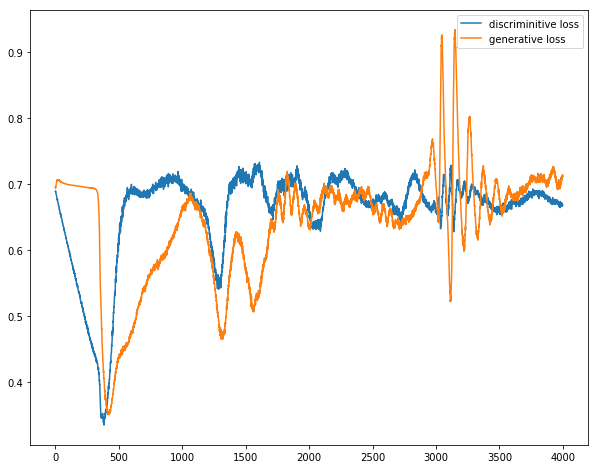

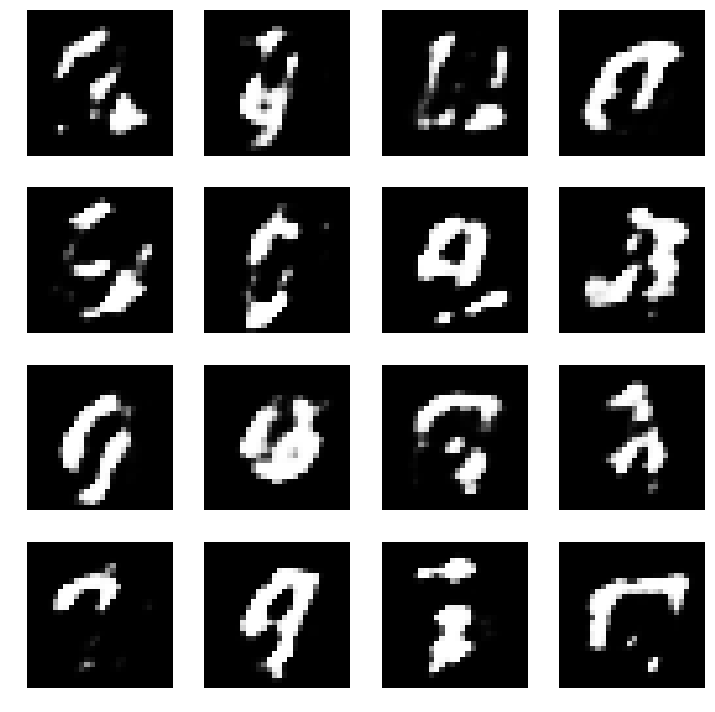

100%|██████████| 2000/2000 [44:14<00:00,  1.33s/it]


In [45]:
K.set_value(opt.lr, 1e-5)
K.set_value(dopt.lr, 1e-6)
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=256)

# cGAN

* https://habrahabr.ru/post/332000/

* https://github.com/osh/KerasGAN


# Conditional GAN

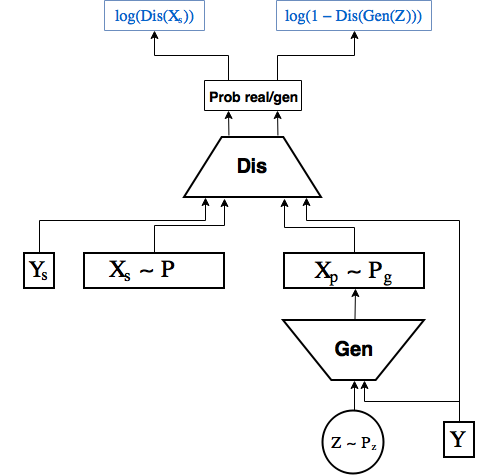